### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### CSV to Data Frame

In [2]:
cpih_data = pd.read_csv("cpih_data.csv", index_col=0, parse_dates=True)

### First Plot of Data

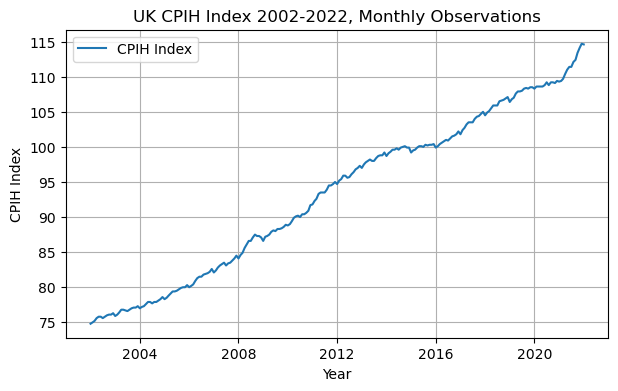

In [3]:
plt.figure(figsize=(7, 4))
plt.plot(cpih_data.index, cpih_data['CPIH'], label="CPIH Index")
plt.title("UK CPIH Index 2002-2022, Monthly Observations")
plt.xlabel("Year")
plt.ylabel("CPIH Index")
plt.legend()
plt.grid(True)
plt.show()

### ADF Test Functions

In [4]:
# Augmented Dickey-Fuller Test (NO TREND).
def adf_test(timeseries):
    print("Results of DF test:")
    dftest = adfuller(
        timeseries,
        maxlag=None,
        regression="c",
        autolag="AIC",
        store=False,
        regresults=False
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "# Lags Used",
            "Number of Observations Used"
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# Augmented Dickey-Fuller Test + CONTINUOUS TREND (ct).
def adf_test_ct(timeseries):
    print("Results of DF test (+ CT):")
    dftest = adfuller(
        timeseries,
        maxlag=None,
        regression="ct",
        autolag="AIC",
        store=False,
        regresults=False
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "# Lags Used",
            "Number of Observations Used"
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

## CPIH Data: Testing ADF & ACF/PACF 

#### ADF Test + Trend

In [5]:
cpih_adf_score = adf_test_ct(cpih_data["CPIH"])

Results of DF test (+ CT):
Test Statistic                  -2.621179
p-value                          0.270241
# Lags Used                     14.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.999396
Critical Value (5%)             -3.430097
Critical Value (10%)            -3.138569
dtype: float64


#### ACF/PACF Plots

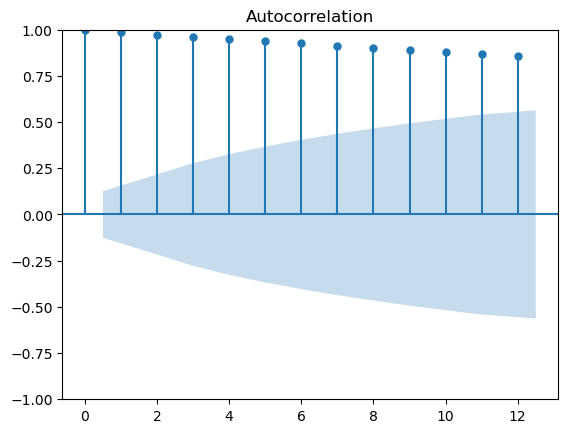

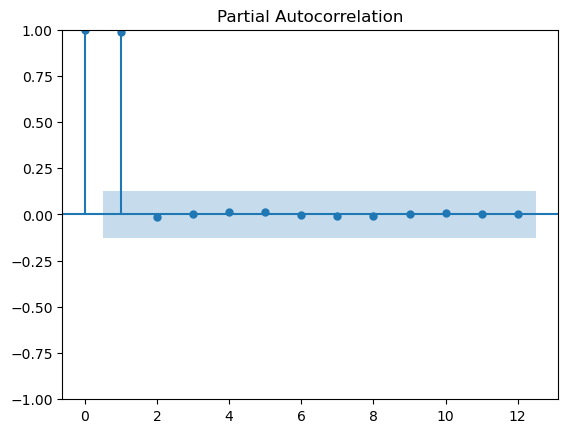

In [8]:
cpih_acf = plot_acf(cpih_data["CPIH"].values.squeeze(), lags=12)
cpih_pacf = plot_pacf(cpih_data["CPIH"].values.squeeze(), lags=12)

## CPIH First Differnce: Testing ADF & ACF/PACF

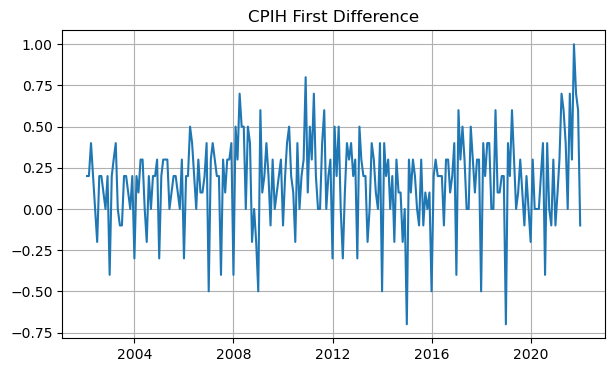

In [21]:
cpih_data_diff = cpih_data.copy()
# First differencing.
cpih_data_diff["CPIH_diff"] = cpih_data_diff["CPIH"] - cpih_data_diff["CPIH"].shift(1)
# Remove first row (NaN value).
cpih_data_diff = cpih_data_diff.iloc[1:]

plt.figure(figsize=(7, 4))
plt.plot(cpih_data_diff['CPIH_diff'])
plt.title("CPIH First Difference")
plt.grid(True)
plt.show()

#### ADF Test

In [23]:
cpih_diff_adf_score = adf_test(cpih_data_diff["CPIH_diff"])

Results of DF test:
Test Statistic                  -2.390673
p-value                          0.144386
# Lags Used                     13.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.874415
Critical Value (10%)            -2.573632
dtype: float64


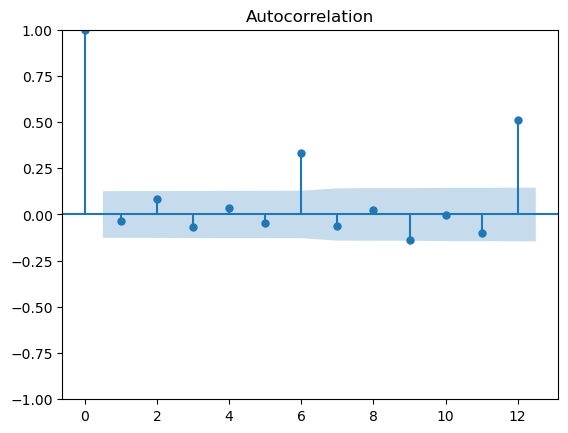

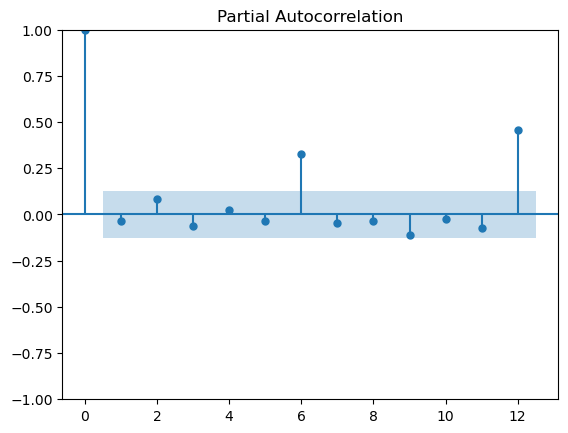

In [24]:
cpih_diff_acf = plot_acf(cpih_data_diff["CPIH_diff"].values.squeeze(), lags=12)
cpih_diff_pacf = plot_pacf(cpih_data_diff["CPIH_diff"].values.squeeze(), lags=12)

## CPIH Second Difference: Testing ADF & ACF/PACF

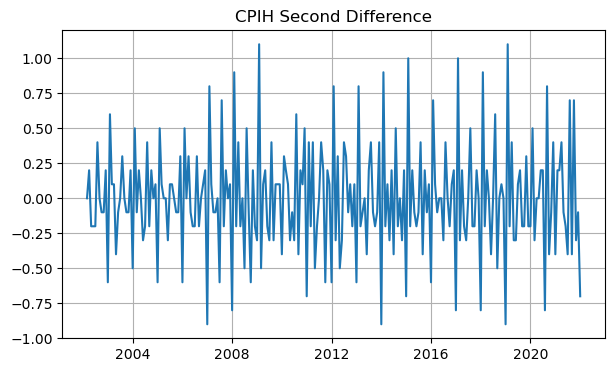

In [27]:
cpih_data_diff_2 = cpih_data_diff.copy()
# First differencing.
cpih_data_diff["CPIH_diff_2"] = cpih_data_diff["CPIH_diff"] - cpih_data_diff["CPIH_diff"].shift(1)
# Remove first row (NaN value).
cpih_data_diff_2 = cpih_data_diff_2.iloc[1:]

plt.figure(figsize=(7, 4))
plt.plot(cpih_data_diff_2['CPIH_diff_2'])
plt.title("CPIH Second Difference")
plt.grid(True)
plt.show()

In [29]:
cpih_diff_2_adf_score = adf_test(cpih_data_diff_2["CPIH_diff_2"])

Results of DF test:
Test Statistic                -6.129756e+00
p-value                        8.457728e-08
# Lags Used                    1.200000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


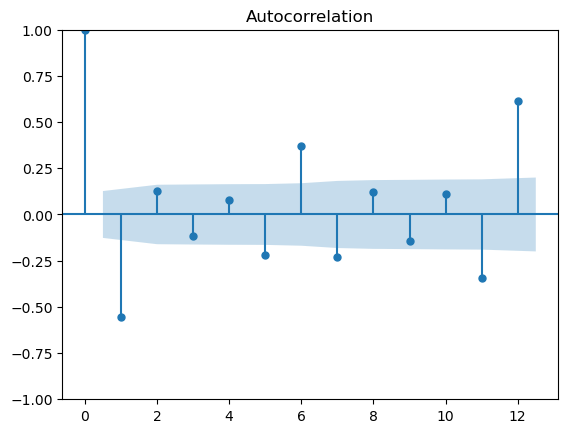

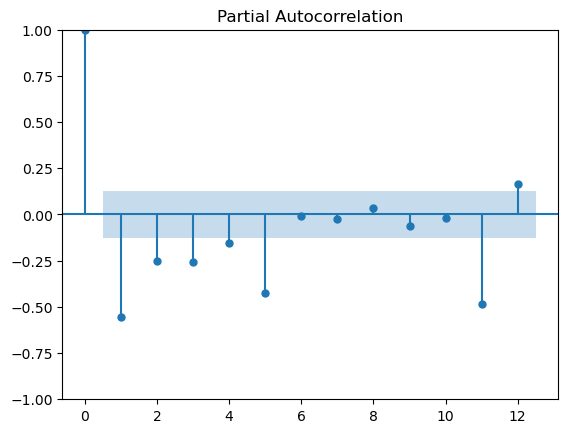

In [30]:
cpih_diff_2_acf = plot_acf(cpih_data_diff_2["CPIH_diff_2"].values.squeeze(), lags=12)
cpih_diff_2_pacf = plot_pacf(cpih_data_diff_2["CPIH_diff_2"].values.squeeze(), lags=12)

### CPIH Second Difference with Seasonal Adjustments: Testing ADF & ACF/PACF

In [31]:
# Begin Here